In [2]:
import re
import math
import copy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from unicodedata import normalize
from einops import rearrange


In [4]:
# -----------
# LOAD DATA
# -----------
df = pd.read_csv(
    'en-fr.txt', 
    names=['en', 'fr', 'attr'], 
    usecols=['en', 'fr'], 
    sep='\t'
)

# Shuffle and reset index
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# -----------
# CLEAN DATA
# -----------
def clean_text(text):
    """Remove punctuation/numbers, lowercase, ASCII-fy."""
    text = normalize('NFD', text.lower())          # e.g. "é" -> "e"
    text = re.sub('[^a-zA-Z ]+', '', text)         # remove anything not a letter or space
    return text.strip()

def clean_and_prepare_text_french(text):
    """For French side, prepend [start] and append [end]."""
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(clean_text)
df['fr'] = df['fr'].apply(clean_and_prepare_text_french)

print("Sample rows:")
display(df.head(5))


Sample rows:


,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


In [5]:
# -------------------------
# FIND MAX SEQ LENGTHS
# -------------------------
en_max_len = max(len(line.split()) for line in df['en'])
fr_max_len = max(len(line.split()) for line in df['fr'])
sequence_len = max(en_max_len, fr_max_len)  # we'll unify them for convenience

print(f"Max length (English) = {en_max_len}")
print(f"Max length (French)  = {fr_max_len}")
print(f"Unified sequence_len = {sequence_len}")


Max length (English) = 7
Max length (French)  = 16
Unified sequence_len = 16


In [6]:
# Collect all tokens for English
all_en_tokens = []
for s in df['en']:
    all_en_tokens.extend(s.split())

en_vocab = sorted(list(set(all_en_tokens)))
en_stoi = { w: i+2 for i, w in enumerate(en_vocab) }  
# +2 so we can reserve 0 = [PAD], 1 = [UNK] or other special tokens if you want
en_stoi["[PAD]"] = 0
en_stoi["[UNK]"] = 1

# Collect all tokens for French
all_fr_tokens = []
for s in df['fr']:
    all_fr_tokens.extend(s.split())

fr_vocab = sorted(list(set(all_fr_tokens)))
fr_stoi = { w: i+2 for i, w in enumerate(fr_vocab) }
fr_stoi["[PAD]"] = 0
fr_stoi["[UNK]"] = 1

# For reverse lookups (index->token) in French (useful for inference)
fr_itos = { idx: token for token, idx in fr_stoi.items() }

print("Vocab sizes:")
print(f"English vocab size = {len(en_stoi)}")
print(f"French  vocab size = {len(fr_stoi)}")

en_vocab_size = len(en_stoi)
fr_vocab_size = len(fr_stoi)


Vocab sizes:
English vocab size = 6034
French  vocab size = 12198


In [7]:
def encode_en(line):
    return [en_stoi.get(t, 1) for t in line.split()]  # 1 is [UNK]

def encode_fr(line):
    return [fr_stoi.get(t, 1) for t in line.split()]

def pad_or_trunc(arr, max_len, pad_value=0):
    # If len < max_len: pad; if > max_len: truncate
    arr = arr[:max_len]
    arr += [pad_value]*(max_len - len(arr))
    return arr

encoded_en = []
encoded_fr = []

for idx, row in df.iterrows():
    # English
    en_ids = encode_en(row['en'])
    en_ids = pad_or_trunc(en_ids, sequence_len, pad_value=0)
    encoded_en.append(en_ids)
    
    # French
    fr_ids = encode_fr(row['fr'])
    # We'll keep sequence_len+1 for the French side
    # because we have [start] ... [end] tokens
    fr_ids = pad_or_trunc(fr_ids, sequence_len+1, pad_value=0)
    encoded_fr.append(fr_ids)

encoded_en = np.array(encoded_en, dtype=np.int64)
encoded_fr = np.array(encoded_fr, dtype=np.int64)

print("Encoded shapes:")
print(encoded_en.shape)
print(encoded_fr.shape)

# The model's "decoder input" is everything except the last token ([end]) of FR
# The "target" is everything except the first token ([start]) of FR

decoder_input = encoded_fr[:, :-1]
decoder_target = encoded_fr[:, 1:]


Encoded shapes:
(50000, 16)
(50000, 17)


In [8]:
class TranslationDataset(Dataset):
    def __init__(self, enc_in, dec_in, dec_out):
        self.enc_in = enc_in
        self.dec_in = dec_in
        self.dec_out = dec_out
        
    def __len__(self):
        return len(self.enc_in)
    
    def __getitem__(self, idx):
        return {
            'encoder_input': torch.tensor(self.enc_in[idx], dtype=torch.long),
            'decoder_input': torch.tensor(self.dec_in[idx], dtype=torch.long),
            'decoder_output': torch.tensor(self.dec_out[idx], dtype=torch.long)
        }

# Train/Val split (80/20)
dataset_size = len(encoded_en)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

full_dataset = TranslationDataset(encoded_en, decoder_input, decoder_target)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

print(f"Train set: {len(train_dataset)} samples")
print(f"Val   set: {len(val_dataset)}  samples")


Train set: 40000 samples
Val   set: 10000  samples


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        Returns:
          x + positional_encoding
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


In [10]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention
        src2, _ = self.self_attn(src, src, src, 
                                 attn_mask=src_mask,
                                 key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        
        # Feedforward
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src


In [11]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, 
                memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        # 1) Masked self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, 
                                 attn_mask=tgt_mask,
                                 key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # 2) Multi-head attention over encoder output
        tgt2, _ = self.multihead_attn(tgt, memory, memory, 
                                      attn_mask=memory_mask,
                                      key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        # 3) Feedforward
        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt


In [12]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class TransformerEncoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = clones(layer, num_layers)
        
    def forward(self, src, mask=None, src_key_padding_mask=None):
        out = src
        for layer in self.layers:
            out = layer(out, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
        return out

class TransformerDecoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = clones(layer, num_layers)
        
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, 
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        out = tgt
        for layer in self.layers:
            out = layer(out, memory, tgt_mask=tgt_mask, memory_mask=memory_mask, 
                        tgt_key_padding_mask=tgt_key_padding_mask, 
                        memory_key_padding_mask=memory_key_padding_mask)
        return out


In [13]:
class TransformerNMT(nn.Module):
    def __init__(self, 
                 en_vocab_size, 
                 fr_vocab_size,
                 d_model=256,
                 nhead=8,
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=512,
                 dropout=0.1,
                 max_len=100
                ):
        super().__init__()
        
        self.d_model = d_model
        
        # Embeddings
        self.en_embedding = nn.Embedding(en_vocab_size, d_model, padding_idx=0)
        self.fr_embedding = nn.Embedding(fr_vocab_size, d_model, padding_idx=0)
        
        # Positional Encoding
        self.positional_encoder = PositionalEncoding(d_model, max_len)
        
        # Encoder and Decoder
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers)
        
        # Final linear layer to project to FR vocab
        self.fc_out = nn.Linear(d_model, fr_vocab_size)
        
    def forward(self, 
                src, 
                tgt, 
                src_mask=None, 
                tgt_mask=None,
                src_key_padding_mask=None,
                tgt_key_padding_mask=None):
        """
        src: (batch_size, src_seq_len)
        tgt: (batch_size, tgt_seq_len)
        """
        # 1) Embed + positionally encode
        enc_in = self.en_embedding(src) * math.sqrt(self.d_model)
        enc_in = self.positional_encoder(enc_in)
        
        dec_in = self.fr_embedding(tgt) * math.sqrt(self.d_model)
        dec_in = self.positional_encoder(dec_in)
        
        # 2) Encode
        memory = self.encoder(enc_in, 
                              mask=src_mask, 
                              src_key_padding_mask=src_key_padding_mask)
        
        # 3) Decode
        out = self.decoder(dec_in, memory, 
                           tgt_mask=tgt_mask, 
                           memory_mask=None, 
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=src_key_padding_mask)
        
        # 4) Final linear to vocab
        logits = self.fc_out(out)  # (batch_size, tgt_seq_len, fr_vocab_size)
        return logits


In [14]:
def generate_subsequent_mask(seq_len):
    """
    Generate a triangular (subsequent) mask for the decoder so each position 
    only sees previous positions (including itself).
    Shape: (seq_len, seq_len)
    """
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    # mask[i, j] = True means "block" so we invert it
    mask = ~mask
    return mask  # True means allow, False means block or vice versa—just be consistent


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print("Using device:", device)

# Hyperparams
d_model = 256
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
lr = 1e-4
num_epochs = 10

model = TransformerNMT(
    en_vocab_size=en_vocab_size,
    fr_vocab_size=fr_vocab_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    max_len=sequence_len+1  # just in case
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # pad is index 0
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def compute_accuracy(logits, target):
    """
    logits: (B, T, vocab_size)
    target: (B, T)
    Return % correct ignoring PAD=0
    """
    preds = logits.argmax(dim=-1)
    mask = (target != 0)
    correct = (preds == target) & mask
    acc = correct.sum().item() / mask.sum().item()
    return acc

train_accuracies = []
val_accuracies = []
best_val_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    count = 0
    
    for batch in train_loader:
        src = batch['encoder_input'].to(device)   # (B, seq_len)
        tgt_in = batch['decoder_input'].to(device)
        tgt_out = batch['decoder_output'].to(device)
        
        # Create a subsequent mask for the decoder
        seq_len_tgt = tgt_in.size(1)
        tgt_mask = generate_subsequent_mask(seq_len_tgt).to(device)  # (T, T)
        
        # Forward
        logits = model(
            src, 
            tgt_in, 
            tgt_mask=tgt_mask
        )
        
        # Compute loss
        # Reshape logits to (B*T, vocab_size) and target to (B*T)
        logits_reshaped = logits.view(-1, fr_vocab_size)
        tgt_out_reshaped = tgt_out.view(-1)
        
        loss = criterion(logits_reshaped, tgt_out_reshaped)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy on this batch
        acc = compute_accuracy(logits, tgt_out)
        
        total_loss += loss.item()
        total_acc  += acc
        count += 1
    
    train_acc_epoch = total_acc / count
    
    # ---------- Validation ----------
    model.eval()
    val_acc_epoch = 0.0
    val_count = 0
    with torch.no_grad():
        for batch in val_loader:
            src = batch['encoder_input'].to(device)
            tgt_in = batch['decoder_input'].to(device)
            tgt_out = batch['decoder_output'].to(device)
            
            seq_len_tgt = tgt_in.size(1)
            tgt_mask = generate_subsequent_mask(seq_len_tgt).to(device)
            
            logits = model(src, tgt_in, tgt_mask=tgt_mask)
            acc = compute_accuracy(logits, tgt_out)
            
            val_acc_epoch += acc
            val_count += 1
    val_acc_epoch /= val_count
    
    # Track
    train_accuracies.append(train_acc_epoch)
    val_accuracies.append(val_acc_epoch)
    
    # Track best
    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc_epoch:.4f} | Val Acc: {val_acc_epoch:.4f}")


Using device: mps
Epoch 1/10 | Train Acc: 0.3403 | Val Acc: 0.4197
Epoch 2/10 | Train Acc: 0.4501 | Val Acc: 0.4756
Epoch 3/10 | Train Acc: 0.4947 | Val Acc: 0.5108
Epoch 4/10 | Train Acc: 0.5309 | Val Acc: 0.5400
Epoch 5/10 | Train Acc: 0.5629 | Val Acc: 0.5605
Epoch 6/10 | Train Acc: 0.5917 | Val Acc: 0.5823
Epoch 7/10 | Train Acc: 0.6177 | Val Acc: 0.6003
Epoch 8/10 | Train Acc: 0.6436 | Val Acc: 0.6147
Epoch 9/10 | Train Acc: 0.6656 | Val Acc: 0.6251
Epoch 10/10 | Train Acc: 0.6869 | Val Acc: 0.6352


In [17]:
model.load_state_dict(best_model_state)
print(f"Best validation accuracy = {best_val_acc:.4f}")


Best validation accuracy = 0.6352


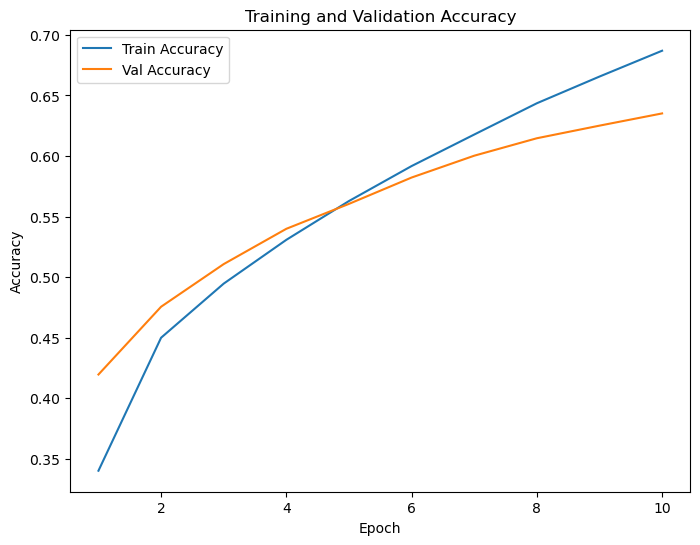

In [18]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies)+1),   val_accuracies,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


In [19]:
def translate_sentence(sentence, model, max_len=16):
    model.eval()
    
    # 1) Encode the English sentence
    cleaned = clean_text(sentence)
    en_ids = [en_stoi.get(t, 1) for t in cleaned.split()]  # 1 = [UNK]
    en_ids = pad_or_trunc(en_ids, sequence_len, 0)
    src_tensor = torch.tensor(en_ids, dtype=torch.long).unsqueeze(0).to(device)
    
    # We'll build up the decoder input one token at a time
    # Start with [start] token in French (which we must find in fr_stoi)
    start_idx = fr_stoi.get("[start]", 1)
    end_idx   = fr_stoi.get("[end]", 1)
    
    # Our partial decoder input
    generated = [start_idx]
    
    for i in range(max_len):
        tgt_tensor = torch.tensor(generated, dtype=torch.long).unsqueeze(0).to(device)
        
        # Make subsequent mask
        tgt_mask = generate_subsequent_mask(tgt_tensor.size(1)).to(device)
        
        with torch.no_grad():
            out = model(src_tensor, tgt_tensor, tgt_mask=tgt_mask)
            # out: (1, seq_len, fr_vocab_size)
            next_token_logits = out[0, -1, :]  # final token predictions
            next_token_id = next_token_logits.argmax().item()
        
        generated.append(next_token_id)
        
        if next_token_id == end_idx:
            break
    
    # Convert generated token IDs back to text
    # strip off the initial [start]
    decoded_tokens = [fr_itos.get(tok_id, "[UNK]") for tok_id in generated]
    # e.g. "[start]" "salut" "le" "monde" "[end]"
    # remove the first token ([start]) and anything after [end]
    
    if "[start]" in decoded_tokens:
        decoded_tokens.remove("[start]")
    if "[end]" in decoded_tokens:
        end_pos = decoded_tokens.index("[end]")
        decoded_tokens = decoded_tokens[:end_pos]
    
    return " ".join(decoded_tokens)


In [20]:
test_phrases = [
    "Hello world",
    "I love winning",
    "It was quite funny",
    "Fortune smiled on him",
    "Where is Boston",
    "You see what I mean",
]

for s in test_phrases:
    translation = translate_sentence(s, model)
    print(f'EN: {s}\nFR: {translation}\n')


EN: Hello world
FR: ca va

EN: I love winning
FR: jadore le the

EN: It was quite funny
FR: cetait assez amusant

EN: Fortune smiled on him
FR: lui sourit sur lui

EN: Where is Boston
FR: ou est boston

EN: You see what I mean
FR: je vois ce que vous voulez dire

